In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [2]:
# Load the data
bank_df = pd.read_csv('DMBA-R-datasets/UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# data preprocess
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

# split the train and validation data
x = bank_df.drop(['Personal_Loan', 'ZIP_Code', 'ID'], axis='columns')
y = bank_df['Personal_Loan']
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = .4, random_state = 1)

### Tree Method (with tree pruning via cost-complexity parameter tunning and grid search)

In [4]:
# fit the tree
fulltree = DecisionTreeClassifier(random_state=2)
fulltree.fit(train_x, train_y)

DecisionTreeClassifier(random_state=2)

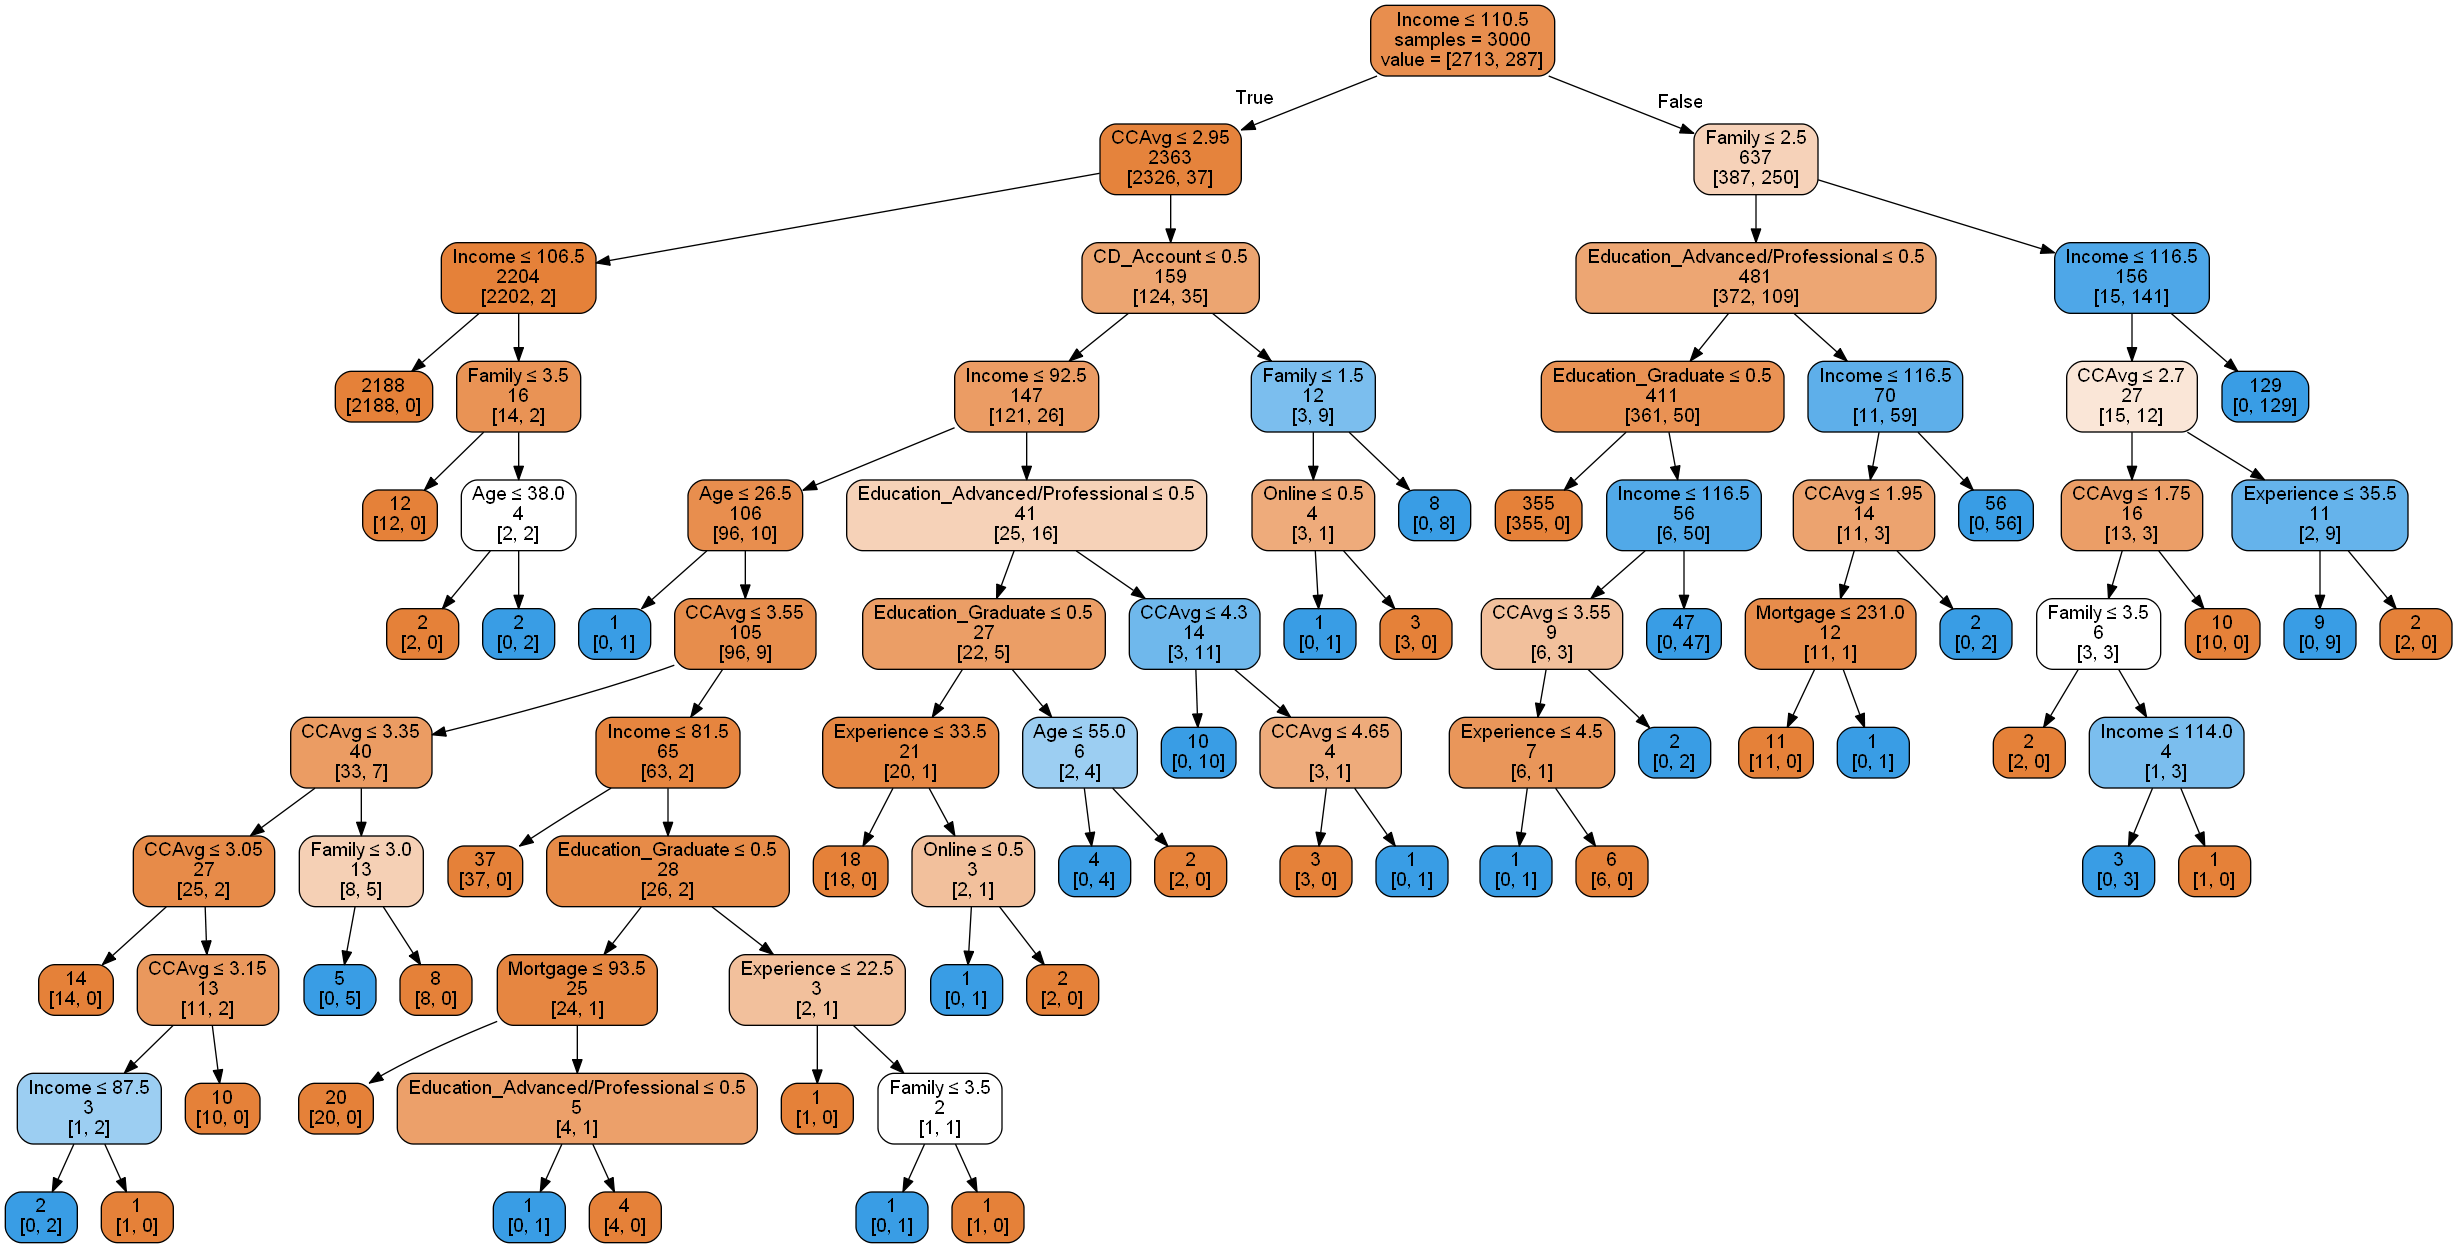

In [5]:
# plot the tree
plotDecisionTree(fulltree, feature_names=train_x.columns)

#### 1. using GridSearchCV to fine tune method parameters

In [7]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth':[5,10,20,],
    'min_samples_split':[20,40,60,80],
    'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01]
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=1)
gridSearch.fit(train_x, train_y)

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.9833333333333334
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}


In [8]:
# Adapt grid based on result from initial grid search
param_grid = {
 'max_depth': list(range(3,12)), 
 'min_samples_split': list(range(15, 35)), 
 'min_impurity_decrease': [x/10000 for x in range(1, 900, 5)], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_x, train_y)

print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

Improved score:  0.9836666666666668
Improved parameters:  {'max_depth': 7, 'min_impurity_decrease': 0.0001, 'min_samples_split': 15}


In [9]:
# fit the final model with best parameters: {'max_depth': 7, 'min_impurity_decrease': 0.0001, 'min_samples_split': 15}

# prunedtree = gridSearch.best_estimator_
# or:
prunedtree = DecisionTreeClassifier(random_state = 1, max_depth=7, min_impurity_decrease=0.0001, min_samples_split=15)
prunedtree.fit(train_x, train_y)

classificationSummary(train_y, prunedtree.predict(train_x))
classificationSummary(val_y, prunedtree.predict(val_x))

Confusion Matrix (Accuracy 0.9897)

       Prediction
Actual    0    1
     0 2703   10
     1   21  266
Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1796   11
     1   23  170


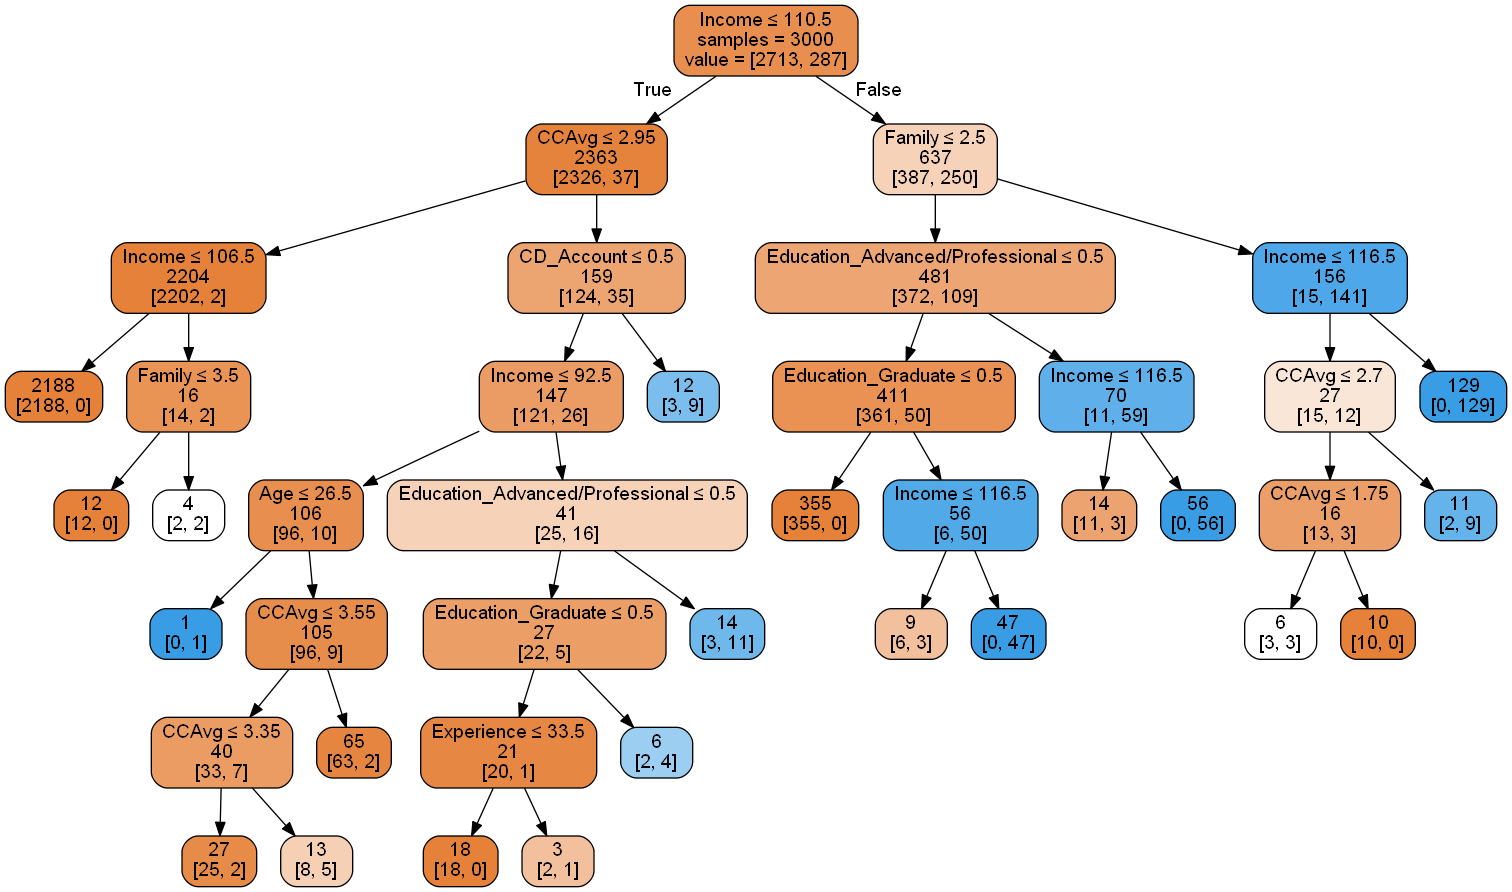

In [10]:
plotDecisionTree(prunedtree, feature_names=train_x.columns)

#### 2. prune the tree with cost complexity pruning - Cross Validation

In [11]:
path = fulltree.cost_complexity_pruning_path(train_x, train_y)
alphas, impurities = path.ccp_alphas, path.impurities

mean, std = [], []
for i in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=i, random_state=0)
#     cross validation for each alpha value
    scores = cross_val_score(tree, x, y, cv=5)
    mean.append(scores.mean())
    std.append(scores.std())
# keep a record of the values of alpha, mean, standard deviation
eva_df = pd.DataFrame({'alpha': alphas, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df.head(10)

,alpha,mean,std
4,0.000444,0.9854,0.001855
3,0.000412,0.9850,0.002757
5,0.000500,0.9850,0.002449
6,0.000500,0.9850,0.002449
7,0.000500,0.9850,0.002449
8,0.000571,0.9846,0.002417
9,0.000611,0.9846,0.002417
10,0.000625,0.9846,0.002417
2,0.000317,0.9844,0.003323
14,0.000960,0.9842,0.002315


In [13]:
# fit the pruned tree - cv
prunedtree_cv = DecisionTreeClassifier(ccp_alpha=eva_df.iloc[4, 0], random_state=0)
prunedtree_cv.fit(train_x, train_y)

classificationSummary(train_y, prunedtree_cv.predict(train_x))
classificationSummary(val_y, prunedtree_cv.predict(val_x))

Confusion Matrix (Accuracy 0.9960)

       Prediction
Actual    0    1
     0 2713    0
     1   12  275
Confusion Matrix (Accuracy 0.9805)

       Prediction
Actual    0    1
     0 1800    7
     1   32  161


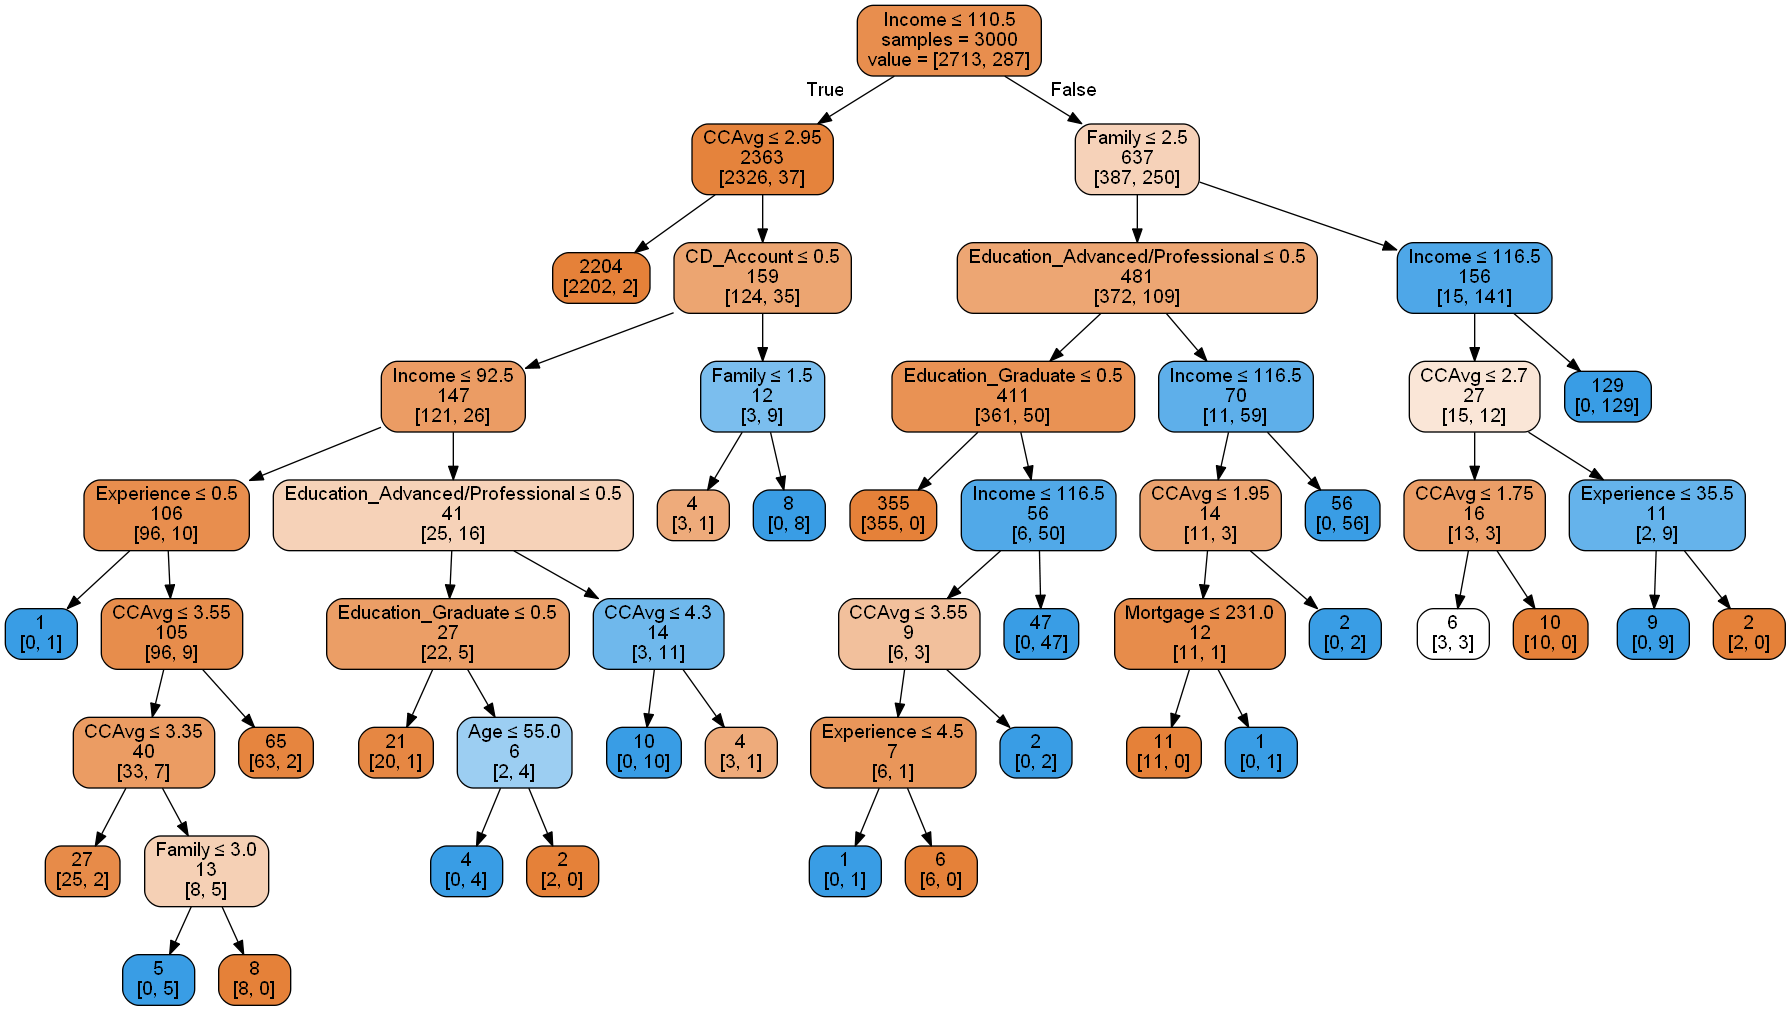

In [14]:
plotDecisionTree(prunedtree_cv, feature_names=train_x.columns)

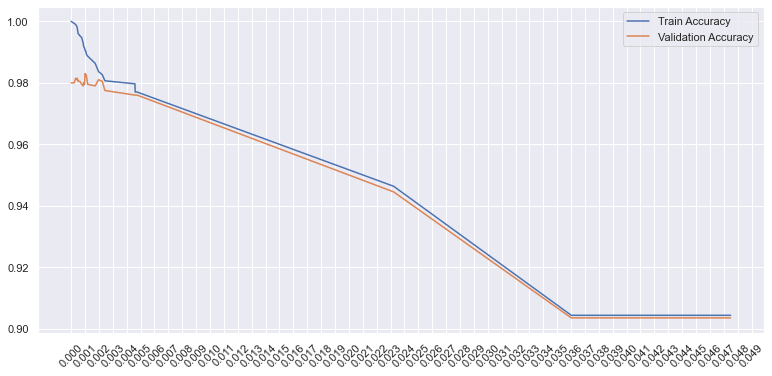

In [15]:
# tree pruning without cross validation
accuracy_train, accuracy_val = [], []
clfs = []
    
for i in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=i, random_state=0)
    tree.fit(train_x, train_y)
    clfs.append(tree)
    
    train_y_pred = tree.predict(train_x)
    val_y_pred = tree.predict(val_x)
    accuracy_train.append(accuracy_score(train_y, train_y_pred))
    accuracy_val.append(accuracy_score(val_y, val_y_pred))

sns.set()
plt.figure(figsize=(13, 6))
sns.lineplot(y = accuracy_train, x = alphas, label = 'Train Accuracy')
sns.lineplot(y = accuracy_val, x = alphas, label = 'Validation Accuracy')
plt.xticks(ticks = np.arange(0, 0.05, 0.001), rotation = 45)
plt.show()

In [17]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

eva_df2 = pd.DataFrame({'alpha': alphas, 'node_counts':node_counts, 'depth': depth,
                       'acc_train':accuracy_train, 'acc_val':accuracy_val,
                      'acc_diff': np.array(accuracy_train) - np.array(accuracy_val)})
eva_df2.sort_values(by = ['acc_val', 'node_counts'], ascending = False).iloc[:10,:]

,alpha,node_counts,depth,acc_train,acc_val,acc_diff
15,0.001000,31,6,0.990667,0.9830,0.007667
16,0.001071,29,6,0.990000,0.9825,0.007500
17,0.001091,27,6,0.989333,0.9825,0.006833
2,0.000317,73,10,0.999000,0.9815,0.017500
4,0.000444,61,8,0.997667,0.9815,0.016167
3,0.000412,67,8,0.998333,0.9810,0.017333
20,0.001971,19,5,0.983667,0.9810,0.002667
5,0.000500,53,8,0.996000,0.9805,0.015500
6,0.000500,53,8,0.996000,0.9805,0.015500
7,0.000500,53,8,0.996000,0.9805,0.015500


In [18]:
# fit the pruned tree - non cv
prunedtree3 = DecisionTreeClassifier(ccp_alpha=eva_df2.iloc[17, 0], random_state=0)
prunedtree3.fit(train_x, train_y)

classificationSummary(train_y, prunedtree3.predict(train_x))
classificationSummary(val_y, prunedtree3.predict(val_x))

Confusion Matrix (Accuracy 0.9893)

       Prediction
Actual    0    1
     0 2703   10
     1   22  265
Confusion Matrix (Accuracy 0.9825)

       Prediction
Actual    0    1
     0 1796   11
     1   24  169


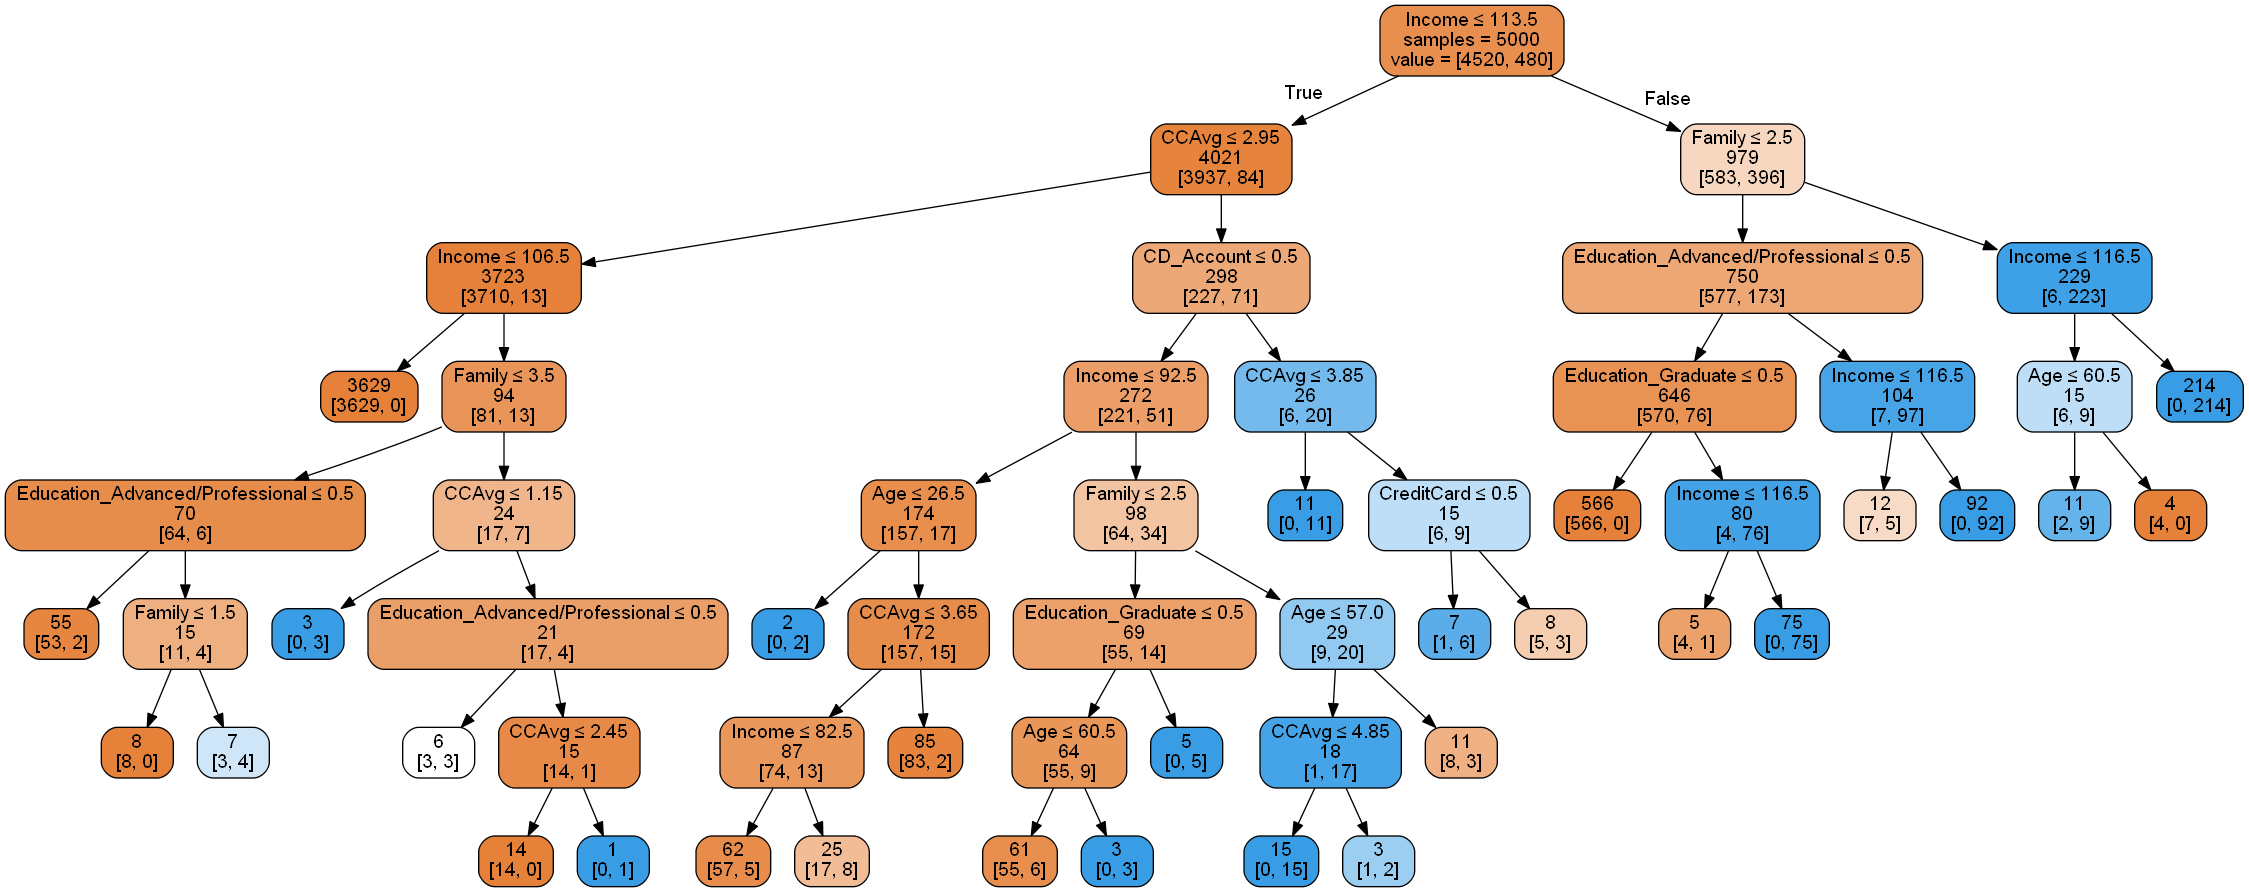

In [21]:
# Implementation
# By comparing the accuracy results from the 3 evaluations, grid search wins with validation accuracy of 98.3%
# Now fit a model with all the data we have so that it's more robust
tree_final = DecisionTreeClassifier(random_state = 1, max_depth=7, min_impurity_decrease=0.0001, min_samples_split=15)
tree_final.fit(x, y)
plotDecisionTree(tree_final, feature_names = x.columns)

reference:
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/stable/modules/cross_validation.html